In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)
# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
first_row_msrmnt = session.query(Measurement).first()
first_row_msrmnt.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18d1595d6c8>,
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01'}

In [10]:
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18d15975a48>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(f"The recent date is {recent_date.date}")

The recent date is 2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [13]:

# Perform a query to retrieve the data and precipitation scores

precip_data=session.query(Measurement.date,Measurement.prcp).\
            filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(precip_data,columns=['date','precip'])
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
prcp_df.set_index('date', inplace=True)
prcp_df = prcp_df.dropna()
prcp_df.head(15)

,precip
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


In [14]:
# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')

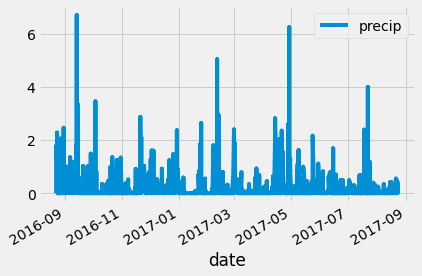

In [15]:
# plt.style.use('fivethirtyeight')
prcp_df.plot(kind='line')
plt.show()

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
# ax = prcp_df.plot(rot=90)
# ax.set_ylabel("Inches")
# plt.ylim(0,8)
# import matplotlib.dates as mdates
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
# plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_summary=prcp_df.describe()
prcp_summary


,precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
station_numbers = session.query(Station).count()
print(f"The total number of stations are {station_numbers} ")

The total number of stations are 9 


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
session.query(Measurement.station,func.count(Measurement.station)).\
           group_by(Measurement.station).\
           order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
active_station = session.query(Measurement.station,func.count(Measurement.station)).\
           group_by(Measurement.station).\
           order_by(func.count(Measurement.station).desc()).first()
# print(f"The most active station is {stations[0]}")
active_station

('USC00519281', 2772)

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp =session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').scalar()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').scalar()
print(f"The lowest temperature is {min_temp}")
print(f"The highest temperature is {max_temp}")
print(f"The average temperature is {avg_temp}")

The lowest temperature is 54.0
The highest temperature is 85.0
The average temperature is 71.66378066378067


In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data=session.query(Measurement.tobs).filter(Measurement.station =='USC00519281').\
                                     filter(Measurement.date >= query_date).all()


In [26]:
temp_df= pd.DataFrame(temp_data,columns=['tobs'])
temp_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


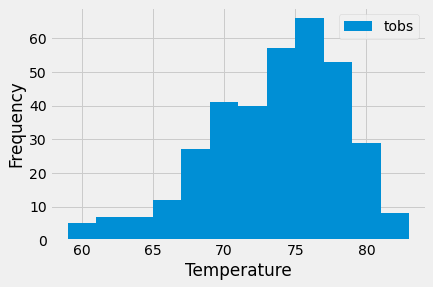

In [27]:
temp_df.plot.hist(by='tobs',bins=12)
plt.xlabel("Temperature")
plt.show()

# Close session

In [28]:
# Close Session
session.close()